# Part-of-Speech (PoS) Tagging using HMM

This notebook implements different configurations of Hidden Markov Models for PoS tagging:
1. First Order HMM with word probability depending only on current tag
2. Second Order HMM with word probability depending only on current tag
3. First Order HMM with word probability depending on current tag and previous word

Dataset: English Penn Treebank (PTB) corpus

In [36]:
import numpy as np
from collections import defaultdict, Counter
from nltk.corpus import treebank
import random
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import nltk
import json
import matplotlib.pyplot as plt
import seaborn as sns


## HMM Implementation
Implementation of the HMM tagger class that supports all configurations

In [37]:
import numpy as np
from collections import defaultdict

class HMMTagger:
    def __init__(self, order=1, word_dependency='tag'):
        self.order = order
        self.word_dependency = word_dependency  # 'tag' or 'tag_prev_word'
        self.transition_probs = {}
        self.emission_probs = {}
        self.tag_counts = None
        self.default_tag = None

    def train(self, train_data):
        transition_counts = defaultdict(lambda: defaultdict(int))
        emission_counts = defaultdict(lambda: defaultdict(int))
        tag_counts = defaultdict(int)

        # Get default tag (most frequent tag in dataset)
        self.default_tag = self._get_most_frequent_tag(train_data)

        for sentence in train_data:
            prev_tags = ['<s>'] * self.order  # Track n previous tags
            prev_word = '<s>'

            for word, tag in sentence:
                # Handle transitions
                if self.order == 1:
                    transition_counts[prev_tags[0]][tag] += 1
                else:  # Second-order HMM
                    transition_counts[tuple(prev_tags)][tag] += 1

                # Handle emissions
                if self.word_dependency == 'tag':
                    emission_counts[tag][word] += 1
                else:  # tag_prev_word dependency
                    emission_counts[(tag, prev_word)][word] += 1

                tag_counts[tag] += 1

                # Update history
                prev_tags = (prev_tags + [tag])[1:]
                prev_word = word

        # Calculate probabilities with Laplace Smoothing
        self._calculate_probabilities(transition_counts, emission_counts, tag_counts)

    def _calculate_probabilities(self, transition_counts, emission_counts, tag_counts):
        """ Computes transition and emission probabilities with smoothing. """
        self.transition_probs = {}

        # Compute transition probabilities
        for context, transitions in transition_counts.items():
            total = sum(transitions.values()) + len(tag_counts)  # + |V| for smoothing
            self.transition_probs[context] = {
                tag: (count + 1) / total for tag, count in transitions.items()
            }

        # Compute emission probabilities
        self.emission_probs = {}
        if self.word_dependency == 'tag':
            for tag, emissions in emission_counts.items():
                total = tag_counts[tag] + len(emissions)  # + |V| for smoothing
                self.emission_probs[tag] = {
                    word: (count + 1) / total for word, count in emissions.items()
                }
        else:
            for (tag, prev_word), emissions in emission_counts.items():
                total = sum(emissions.values()) + len(emissions)  # + |V| for smoothing
                self.emission_probs[(tag, prev_word)] = {
                    word: (count + 1) / total for word, count in emissions.items()
                }

        self.tag_counts = tag_counts

    def viterbi(self, sentence):
        """ Implements the Viterbi Algorithm for decoding. """
        tags = list(self.tag_counts.keys())
        V = [{}]  # DP table
        path = {}

        # Initialization step
        for tag in tags:
            # First transition probability
            trans_prob = self.transition_probs.get('<s>', {}).get(tag, 1e-7) \
                if self.order == 1 else \
                self.transition_probs.get(('<s>', '<s>'), {}).get(tag, 1e-7)

            # First emission probability
            emit_prob = self._get_emission_prob(tag, sentence[0], '<s>')

            V[0][tag] = trans_prob * emit_prob
            path[tag] = [tag]

        # Forward pass
        for t in range(1, len(sentence)):
            V.append({})
            new_path = {}

            for tag in tags:
                max_prob, best_prev_tag = float('-inf'), None

                for prev_tag in tags:
                    if self.order == 1:
                        trans_prob = self.transition_probs.get(prev_tag, {}).get(tag, 1e-7)
                    else:  # Second-order HMM
                        prev_prev_tag = path[prev_tag][-2] if len(path[prev_tag]) > 1 else '<s>'
                        trans_prob = self.transition_probs.get((prev_prev_tag, prev_tag), {}).get(tag, 1e-7)

                    emit_prob = self._get_emission_prob(tag, sentence[t], sentence[t-1])

                    prob = V[t-1][prev_tag] * trans_prob * emit_prob

                    if prob > max_prob:
                        max_prob = prob
                        best_prev_tag = prev_tag

                V[t][tag] = max_prob
                new_path[tag] = path[best_prev_tag] + [tag]

            path = new_path

        # Backtracking for best sequence
        final_max_prob, best_final_tag = float('-inf'), None
        for tag in tags:
            if V[-1][tag] > final_max_prob:
                final_max_prob = V[-1][tag]
                best_final_tag = tag

        return path[best_final_tag]

    def _get_most_frequent_tag(self, train_data):
        """ Determines the most frequent tag in the dataset (used for unseen words). """
        tag_counts = defaultdict(int)
        for sentence in train_data:
            for _, tag in sentence:
                tag_counts[tag] += 1
        return max(tag_counts, key=tag_counts.get)  # Most frequent tag

    def _get_emission_prob(self, tag, word, prev_word):
        """ Retrieves emission probability with default handling for unseen words. """
        if self.word_dependency == 'tag':
            return self.emission_probs.get(tag, {}).get(word, self.emission_probs.get(self.default_tag, {}).get(word, 1e-7))
        else:
            return self.emission_probs.get((tag, prev_word), {}).get(word, self.emission_probs.get((self.default_tag, prev_word), {}).get(word, 1e-7))


In [38]:
def analyze_tag_distribution(data):
    """Analyze and print the distribution of tags in the dataset"""
    # Count total occurrences of each tag
    tag_counts = Counter(tag for sent in data for _, tag in sent)

    # Sort tags by frequency
    sorted_tags = sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

    # Calculate total words
    total_words = sum(tag_counts.values())

    print("\nTag Distribution Analysis:")
    print(f"Total words: {total_words}")
    print(f"Total unique tags: {len(tag_counts)}")
    print("\nTag frequencies:")
    print("Tag\tCount\tPercentage")
    print("-" * 30)
    for tag, count in sorted_tags:
        percentage = (count / total_words) * 100
        print(f"{tag}\t{count}\t{percentage:.2f}%")

    # Create histogram
    plt.figure(figsize=(12, 8))
    tags, counts = zip(*sorted_tags)

    # Plot bars
    bars = plt.bar(range(len(tags)), counts)

    # Customize plot
    plt.title('Distribution of POS Tags', fontsize=14)
    plt.xlabel('Tags', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(range(len(tags)), tags, rotation=45, ha='right')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

    return tag_counts

def preprocess_data(data):
    """Preprocess the data and print statistics"""
    # Count sentence lengths
    sent_lengths = [len(sent) for sent in data]

    print("\nData Statistics:")
    print(f"Total sentences: {len(data)}")
    print(f"Average sentence length: {np.mean(sent_lengths):.2f} words")
    print(f"Max sentence length: {max(sent_lengths)} words")
    print(f"Min sentence length: {min(sent_lengths)} words")

    # Count vocabulary size
    vocab = set(word for sent in data for word, _ in sent)
    print(f"Vocabulary size: {len(vocab)} unique words")

    return data

In [39]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_errors(model, test_data):
    """Analyze and visualize common misclassification patterns"""
    # Track errors and confusion matrix
    errors = defaultdict(int)
    total_by_tag = defaultdict(int)

    for sentence in test_data:
        words, true_tags = zip(*sentence)
        pred_tags = model.viterbi(words)

        for word, true_tag, pred_tag in zip(words, true_tags, pred_tags):
            total_by_tag[true_tag] += 1
            if true_tag != pred_tag:
                errors[(word, true_tag, pred_tag)] += 1

    # Print most common errors
    print("\nMost Common Errors:")
    print("Word".ljust(20) + "True Tag".ljust(10) + "Pred Tag".ljust(10) + "Count")
    print("-" * 50)
    for (word, true_tag, pred_tag), count in sorted(errors.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{word:<20}{true_tag:<10}{pred_tag:<10}{count}")

    # Print tags with highest error rates
    print("\nError Rates by Tag:")
    print("Tag".ljust(10) + "Error Rate".ljust(12) + "Total Occurrences")
    print("-" * 40)
    error_rates = {}
    for tag in total_by_tag:
        total_errors = sum(count for (word, true_t, pred_t), count in errors.items() if true_t == tag)
        error_rate = total_errors / total_by_tag[tag] if total_by_tag[tag] > 0 else 0
        error_rates[tag] = error_rate
        print(f"{tag:<10}{error_rate:>8.2%}{total_by_tag[tag]:>15}")

    return errors, error_rates


In [40]:
import matplotlib.pyplot as plt

def plot_sequence_length_distribution(sentences):
    """
    Plots a histogram of sequence lengths in the dataset.

    Parameters:
        sentences (list of list of str): List of sentences, where each sentence is a list of words.
    """
    sequence_lengths = [len(sentence) for sentence in sentences]

    plt.figure(figsize=(10, 5))
    plt.hist(sequence_lengths, bins=range(1, max(sequence_lengths) + 1), edgecolor='black', alpha=0.7)
    plt.xlabel("Sequence Length")
    plt.ylabel("Number of Sequences")
    plt.title("Distribution of Sequence Lengths")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
# Assuming `train_sentences` is a list of tokenized sentences


## Helper Functions

In [41]:
def load_data(split_ratio=0.8):
    # Load data from penn-data.json
    with open('penn-data.json', 'r') as f:
        data = json.load(f)

    # Convert data into the same format as treebank.tagged_sents()
    # Each item in data is [sentence_text, tags]
    sentences = []
    for sentence_data in data:
        text = sentence_data[0].split()  # Split sentence into words
        tags = sentence_data[1]
        if len(text) == len(tags):  # Ensure word and tag counts match
            sentences.append(list(zip(text, tags)))

    sentences = preprocess_data(sentences)
    plot_sequence_length_distribution(sentences)
    analyze_tag_distribution(sentences)

    # Shuffle and split data
    random.shuffle(sentences)
    split = int(len(sentences) * split_ratio)
    return sentences[:split], sentences[split:]



def get_most_frequent_tag(train_data):
    tag_counts = Counter(tag for sent in train_data for _, tag in sent)
    return max(tag_counts.items(), key=lambda x: x[1])[0]


def evaluate_model(model, test_data):
    correct = 0
    total = 0
    tag_wise_correct = defaultdict(int)
    tag_wise_total = defaultdict(int)
    true_tags_list = []
    pred_tags_list = []

    for sentence in test_data:
        words, true_tags = zip(*sentence)
        predicted_tags = model.viterbi(words)

        true_tags_list.extend(true_tags)
        pred_tags_list.extend(predicted_tags)

        for true_tag, pred_tag in zip(true_tags, predicted_tags):
            if true_tag == pred_tag:
                correct += 1
                tag_wise_correct[true_tag] += 1
            tag_wise_total[true_tag] += 1
            total += 1

    # Overall accuracy
    overall_accuracy = correct / total

    # Tag-wise accuracy
    tag_wise_accuracy = {
        tag: tag_wise_correct[tag] / tag_wise_total[tag] if tag_wise_total[tag] > 0 else 0
        for tag in tag_wise_total
    }

    # Compute confusion matrix
    unique_tags = sorted(set(true_tags_list) | set(pred_tags_list))
    cm = confusion_matrix(true_tags_list, pred_tags_list, labels=unique_tags)

    # Plot confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_tags, yticklabels=unique_tags)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Compute precision, recall, and F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_tags_list, pred_tags_list, labels=unique_tags, zero_division=0)

    # Plot each metric separately
    x = np.arange(len(unique_tags))

    # F1-Score Plot
    plt.figure(figsize=(10, 6))
    plt.bar(x, f1_score, color="red", alpha=0.7)
    plt.xticks(x, unique_tags, rotation=45, ha="right")
    plt.xlabel("Tag")
    plt.ylabel("F1-score")
    plt.title("F1-score per Tag")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Precision Plot
    plt.figure(figsize=(10, 6))
    plt.bar(x, precision, color="blue", alpha=0.7)
    plt.xticks(x, unique_tags, rotation=45, ha="right")
    plt.xlabel("Tag")
    plt.ylabel("Precision")
    plt.title("Precision per Tag")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    # Recall Plot
    plt.figure(figsize=(10, 6))
    plt.bar(x, recall, color="green", alpha=0.7)
    plt.xticks(x, unique_tags, rotation=45, ha="right")
    plt.xlabel("Tag")
    plt.ylabel("Recall")
    plt.title("Recall per Tag")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    return overall_accuracy, tag_wise_accuracy, precision, recall, f1_score


## Experiment 1: 36-tag Model
Testing all three HMM configurations with original Penn Treebank tags


Data Statistics:
Total sentences: 3914
Average sentence length: 20.73 words
Max sentence length: 171 words
Min sentence length: 1 words
Vocabulary size: 16458 unique words


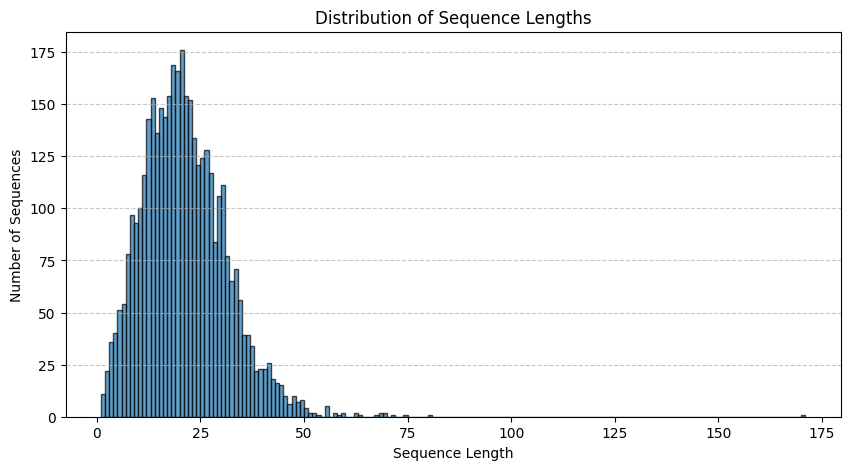


Tag Distribution Analysis:
Total words: 81147
Total unique tags: 41

Tag frequencies:
Tag	Count	Percentage
------------------------------
NN	12721	15.68%
IN	9857	12.15%
NNP	9410	11.60%
DT	8165	10.06%
NNS	6047	7.45%
JJ	5833	7.19%
CD	3546	4.37%
VBD	3043	3.75%
VB	2554	3.15%
RB	2497	3.08%
CC	2265	2.79%
TO	2179	2.69%
VBN	2134	2.63%
VBZ	2022	2.49%
PRP	1716	2.11%
VBG	1460	1.80%
VBP	1279	1.58%
MD	922	1.14%
PRP$	766	0.94%
WDT	445	0.55%
JJR	381	0.47%
:	250	0.31%
NNPS	244	0.30%
WP	241	0.30%
RP	216	0.27%
JJS	182	0.22%
WRB	178	0.22%
RBR	136	0.17%
-RRB-	126	0.16%
-LRB-	120	0.15%
EX	88	0.11%
RBS	35	0.04%
PDT	27	0.03%
#	16	0.02%
WP$	14	0.02%
LS	13	0.02%
''	10	0.01%
FW	4	0.00%
UH	3	0.00%
,	1	0.00%
SYM	1	0.00%


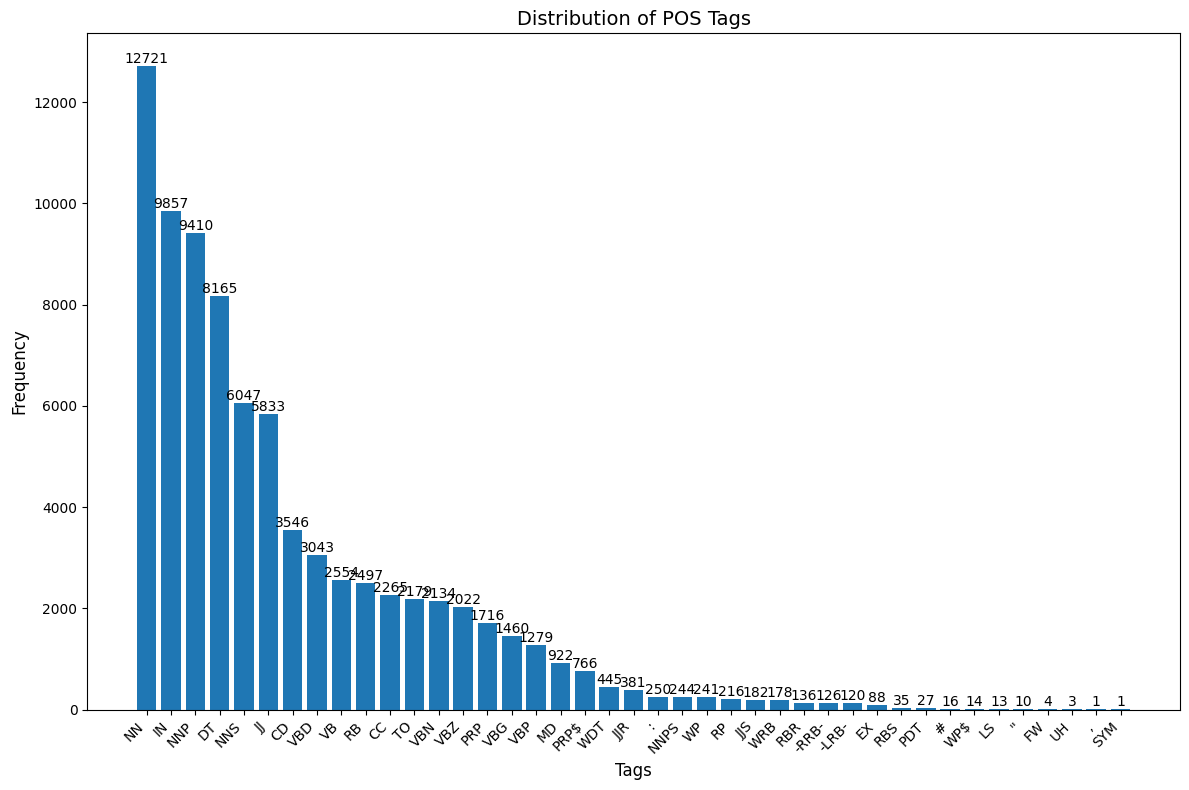


=== 36-TAG MODEL ANALYSIS ===

Analyzing First Order HMM (36 tags):


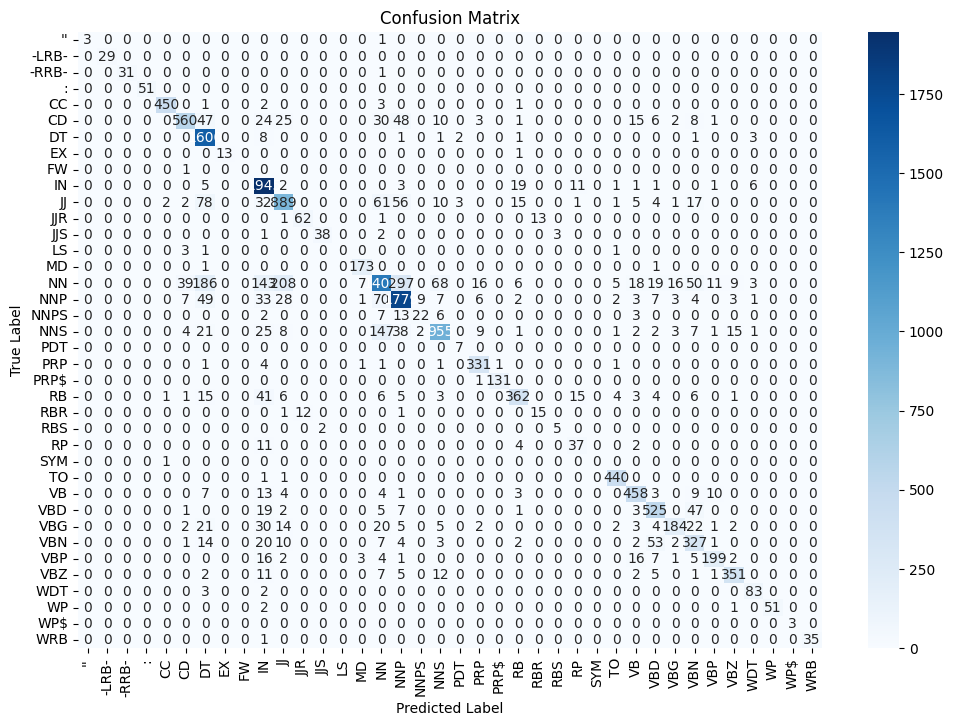

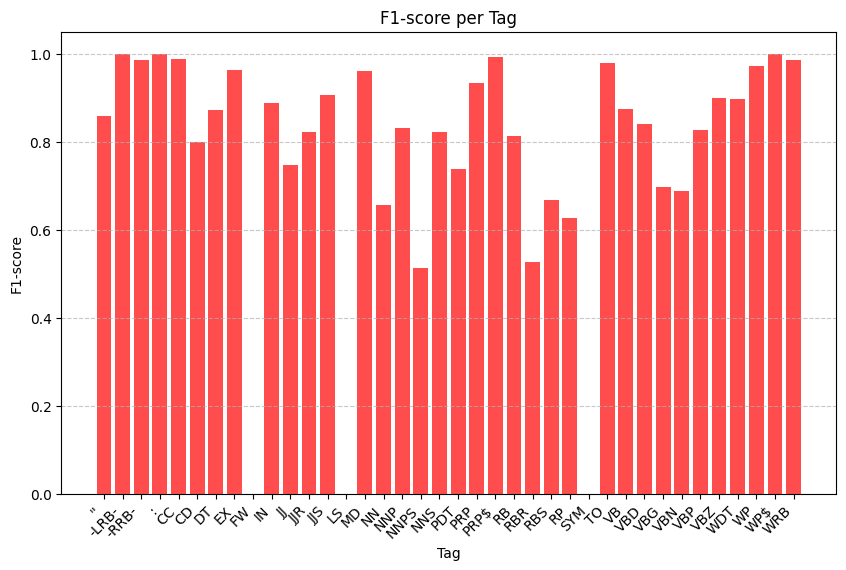

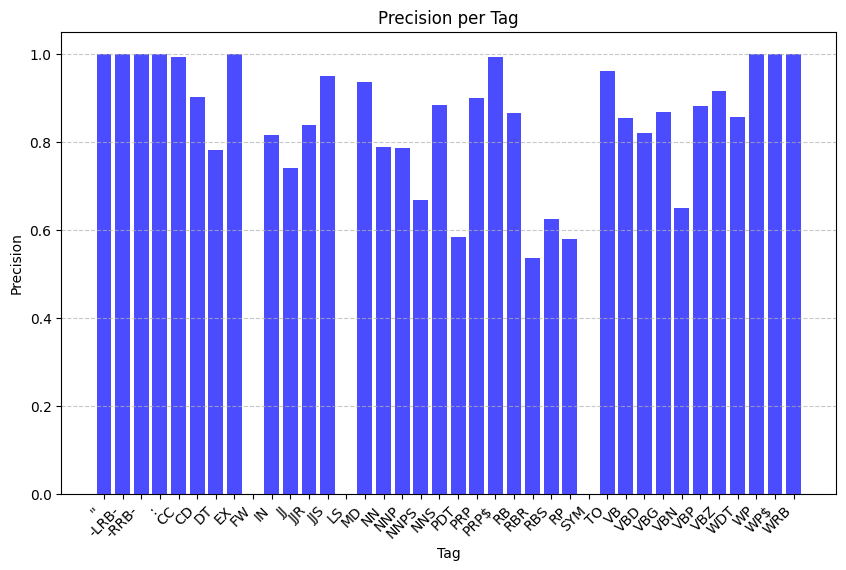

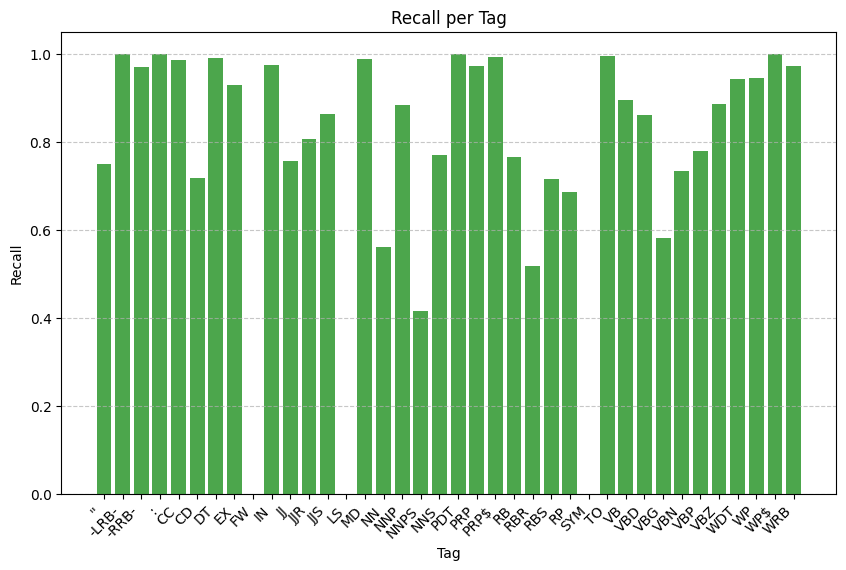


1. First Order HMM (36 tags):
Overall Accuracy: 0.8222
Precision: 0.7883
Recall: 0.7786
F1-score: 0.7778
Tag-wise Accuracy: {'NNP': 0.8833167825223436, 'VBN': 0.7331838565022422, 'IN': 0.974937343358396, 'VBZ': 0.8841309823677582, 'JJ': 0.7553101104502974, 'NNS': 0.7689210950080515, 'CC': 0.9846827133479212, 'PRP': 0.9706744868035191, 'VBD': 0.860655737704918, 'VB': 0.89453125, 'DT': 0.9894867037724181, 'NN': 0.5601278465840991, 'PRP$': 0.9924242424242424, 'WRB': 0.9722222222222222, 'WDT': 0.9431818181818182, 'RB': 0.7653276955602537, 'RP': 0.6851851851851852, 'TO': 0.995475113122172, 'CD': 0.717948717948718, 'VBP': 0.77734375, 'VBG': 0.580441640378549, 'JJR': 0.8051948051948052, 'RBR': 0.5172413793103449, 'MD': 0.9885714285714285, ':': 1.0, 'WP': 0.9444444444444444, 'NNPS': 0.41509433962264153, 'JJS': 0.8636363636363636, 'RBS': 0.7142857142857143, '-LRB-': 1.0, '-RRB-': 0.96875, 'SYM': 0.0, "''": 0.75, 'EX': 0.9285714285714286, 'PDT': 1.0, 'LS': 0.0, 'WP$': 1.0, 'FW': 0.0}

Analyzing

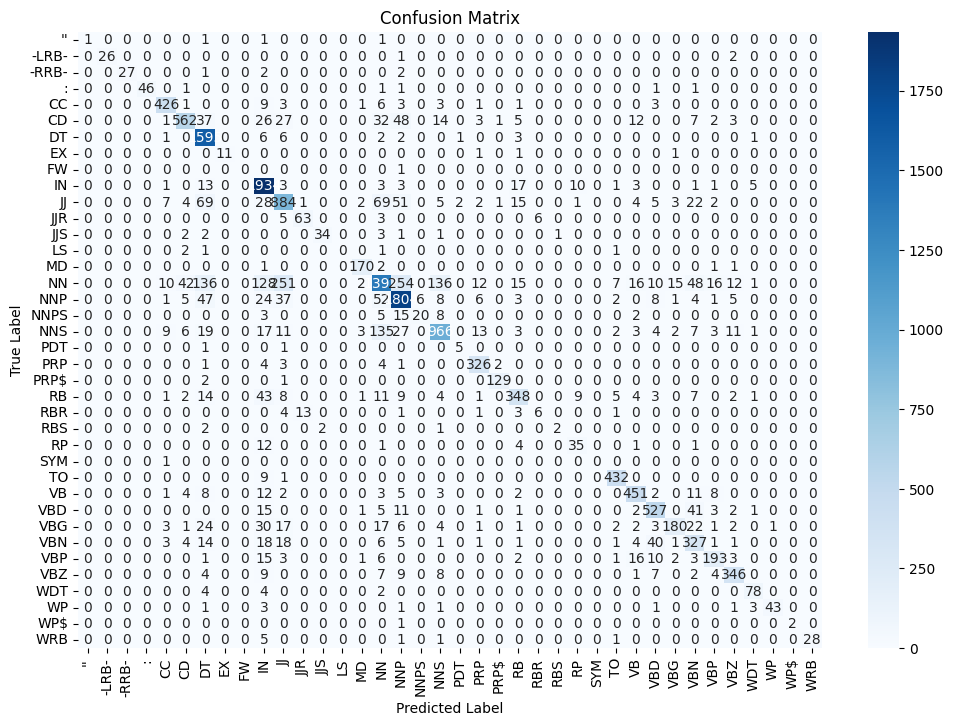

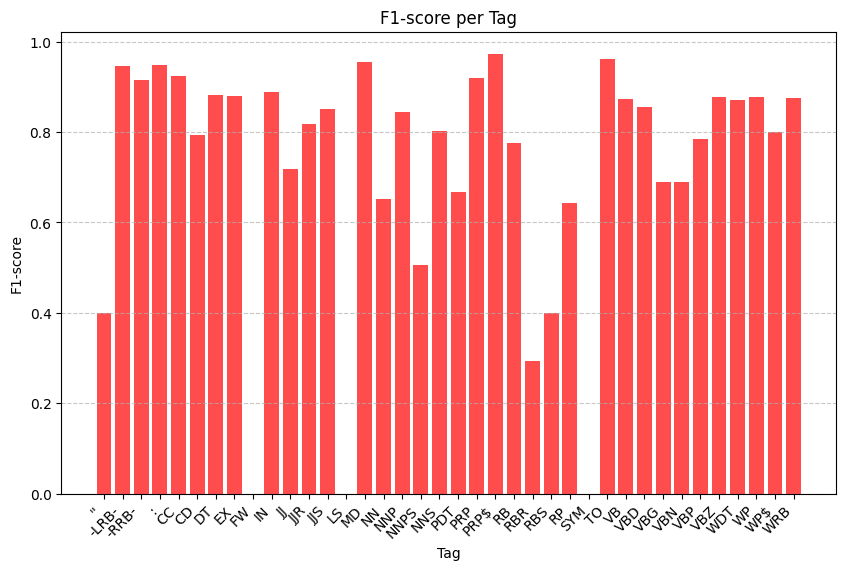

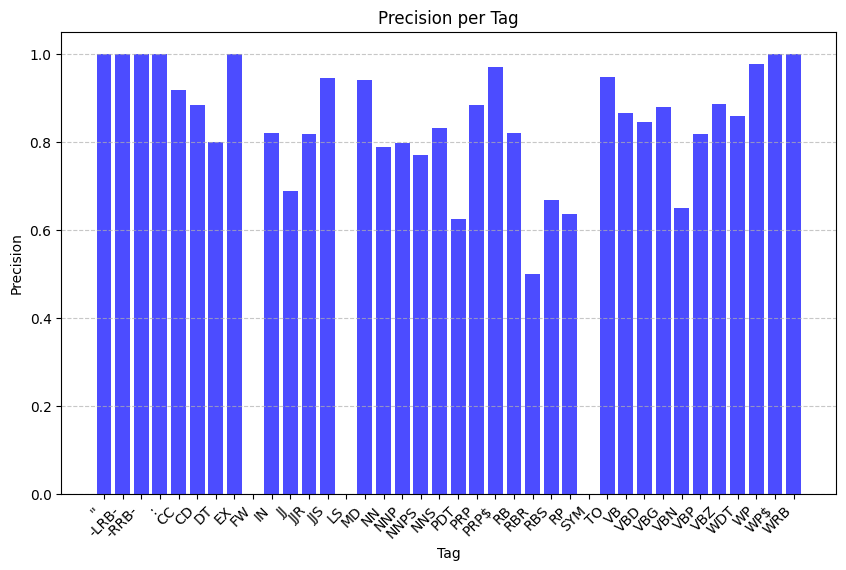

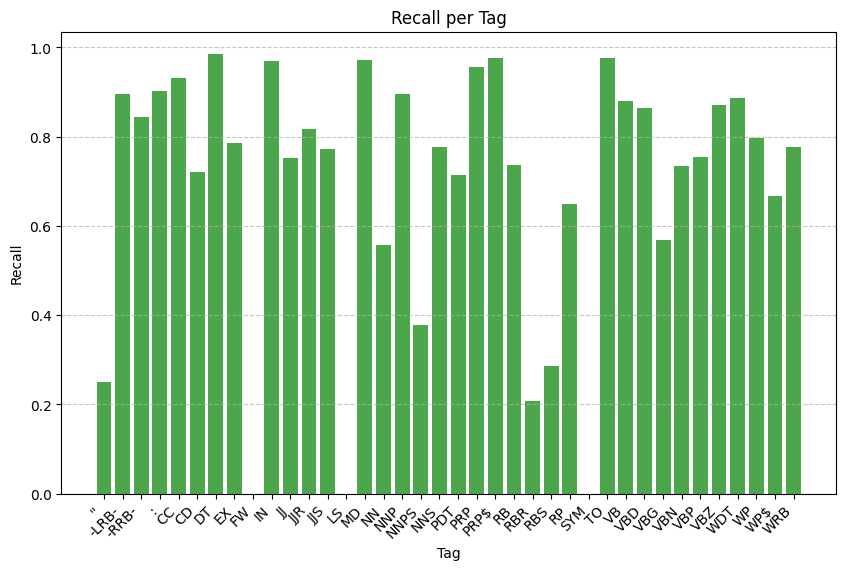


2. Second Order HMM (36 tags):
Overall Accuracy: 0.8145
Precision: 0.7846
Recall: 0.6975
F1-score: 0.7249
Tag-wise Accuracy: {'NNP': 0.8957298907646475, 'VBN': 0.7331838565022422, 'IN': 0.9694235588972431, 'VBZ': 0.871536523929471, 'JJ': 0.7510620220900595, 'NNS': 0.7777777777777778, 'CC': 0.9321663019693655, 'PRP': 0.9560117302052786, 'VBD': 0.8639344262295082, 'VB': 0.880859375, 'DT': 0.9863945578231292, 'NN': 0.5561326408310028, 'PRP$': 0.9772727272727273, 'WRB': 0.7777777777777778, 'WDT': 0.8863636363636364, 'RB': 0.7357293868921776, 'RP': 0.6481481481481481, 'TO': 0.9773755656108597, 'CD': 0.7205128205128205, 'VBP': 0.75390625, 'VBG': 0.5678233438485805, 'JJR': 0.8181818181818182, 'RBR': 0.20689655172413793, 'MD': 0.9714285714285714, ':': 0.9019607843137255, 'WP': 0.7962962962962963, 'NNPS': 0.37735849056603776, 'JJS': 0.7727272727272727, 'RBS': 0.2857142857142857, '-LRB-': 0.896551724137931, '-RRB-': 0.84375, 'SYM': 0.0, "''": 0.25, 'EX': 0.7857142857142857, 'PDT': 0.71428571428

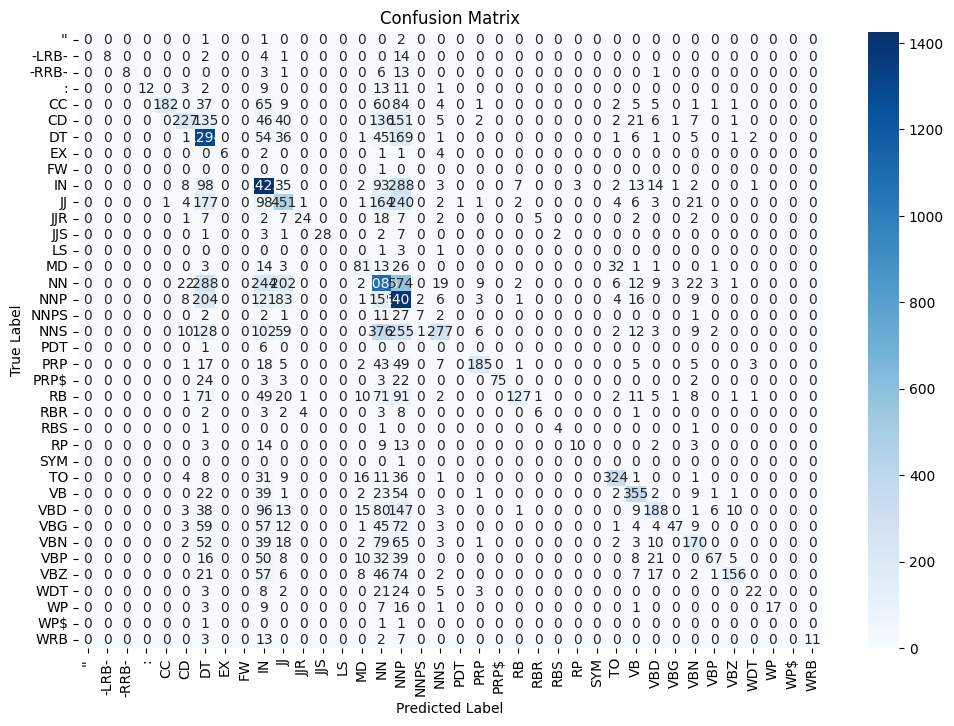

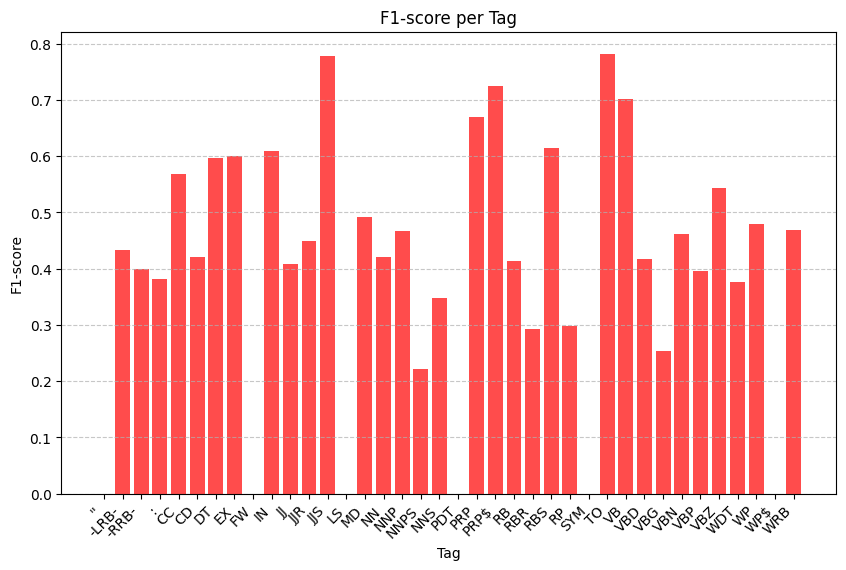

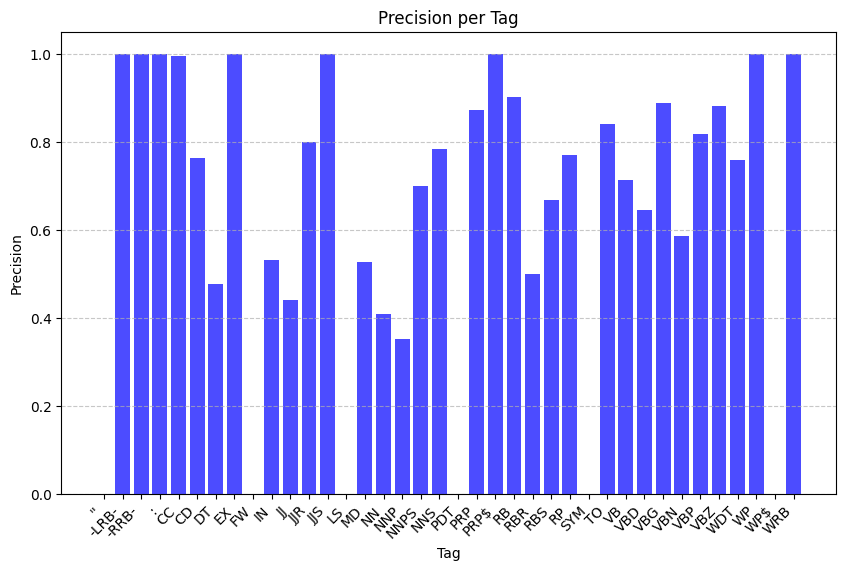

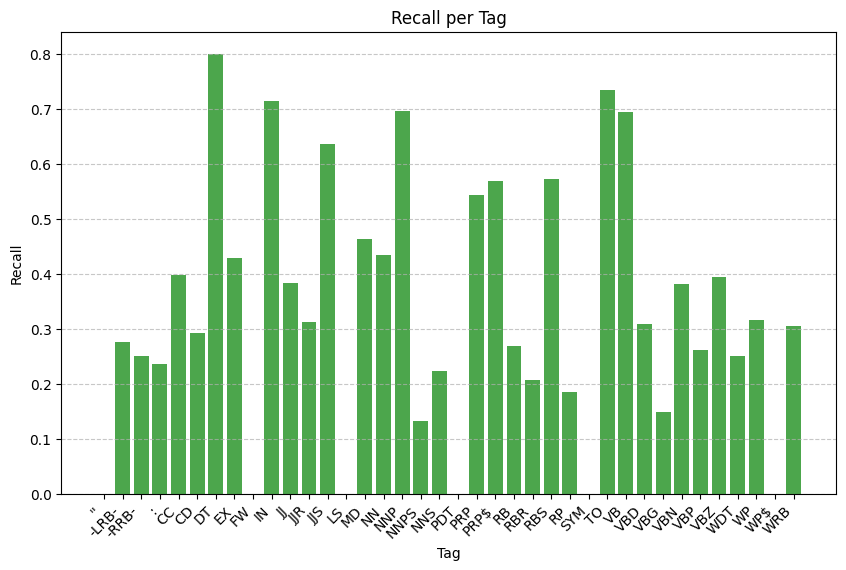


3. First Order HMM with Previous Word (36 tags):
Overall Accuracy: 0.5026
Precision: 0.6474
Recall: 0.3369
F1-score: 0.4076
Tag-wise Accuracy: {'NNP': 0.6956305858987091, 'VBN': 0.3811659192825112, 'IN': 0.7142857142857143, 'VBZ': 0.3929471032745592, 'JJ': 0.38317757009345793, 'NNS': 0.22302737520128824, 'CC': 0.3982494529540481, 'PRP': 0.5425219941348973, 'VBD': 0.3081967213114754, 'VB': 0.693359375, 'DT': 0.8002473716759431, 'NN': 0.4334798242109469, 'PRP$': 0.5681818181818182, 'WRB': 0.3055555555555556, 'WDT': 0.25, 'RB': 0.26849894291754756, 'RP': 0.18518518518518517, 'TO': 0.7330316742081447, 'CD': 0.29102564102564105, 'VBP': 0.26171875, 'VBG': 0.14826498422712933, 'JJR': 0.3116883116883117, 'RBR': 0.20689655172413793, 'MD': 0.46285714285714286, ':': 0.23529411764705882, 'WP': 0.3148148148148148, 'NNPS': 0.1320754716981132, 'JJS': 0.6363636363636364, 'RBS': 0.5714285714285714, '-LRB-': 0.27586206896551724, '-RRB-': 0.25, 'SYM': 0.0, "''": 0.0, 'EX': 0.42857142857142855, 'PDT': 0.

In [42]:
# Load data
train_data, test_data = load_data()

# Configuration 1: First Order HMM with tag-only dependency
print("\n=== 36-TAG MODEL ANALYSIS ===")
print("\nAnalyzing First Order HMM (36 tags):")
model1 = HMMTagger(order=1, word_dependency="tag")
model1.train(train_data)
acc1, tag_acc1, prec1, rec1, f1_1 = evaluate_model(model1, test_data)  # Fixed unpacking
print("\n1. First Order HMM (36 tags):")
print(f"Overall Accuracy: {acc1:.4f}")
print(f"Precision: {prec1.mean():.4f}")
print(f"Recall: {rec1.mean():.4f}")
print(f"F1-score: {f1_1.mean():.4f}")
print("Tag-wise Accuracy:", tag_acc1)

# Configuration 2: Second Order HMM
print("\nAnalyzing Second Order HMM (36 tags):")
model2 = HMMTagger(order=2, word_dependency="tag")
model2.train(train_data)
acc2, tag_acc2, prec2, rec2, f1_2 = evaluate_model(model2, test_data)  # Fixed unpacking
print("\n2. Second Order HMM (36 tags):")
print(f"Overall Accuracy: {acc2:.4f}")
print(f"Precision: {prec2.mean():.4f}")
print(f"Recall: {rec2.mean():.4f}")
print(f"F1-score: {f1_2.mean():.4f}")
print("Tag-wise Accuracy:", tag_acc2)

# Configuration 3: First Order HMM with previous word
print("\nAnalyzing First Order HMM with Previous Word (36 tags):")
model3 = HMMTagger(order=1, word_dependency="tag_prev_word")
model3.train(train_data)
acc3, tag_acc3, prec3, rec3, f1_3 = evaluate_model(model3, test_data)  # Fixed unpacking
print("\n3. First Order HMM with Previous Word (36 tags):")
print(f"Overall Accuracy: {acc3:.4f}")
print(f"Precision: {prec3.mean():.4f}")
print(f"Recall: {rec3.mean():.4f}")
print(f"F1-score: {f1_3.mean():.4f}")
print("Tag-wise Accuracy:", tag_acc3)


## Experiment 2: 4-tag Model
Testing the same configurations with reduced tagset (N, V, A, O)


=== 4-TAG MODEL ANALYSIS ===

Analyzing 1-Order HMM with tag dependency (4 tags):


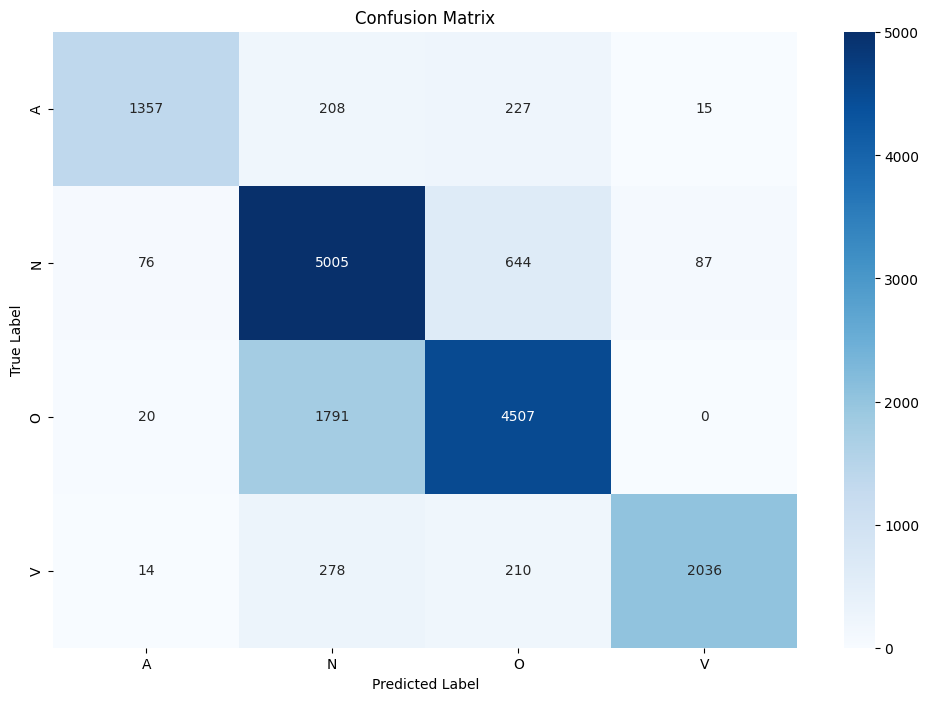

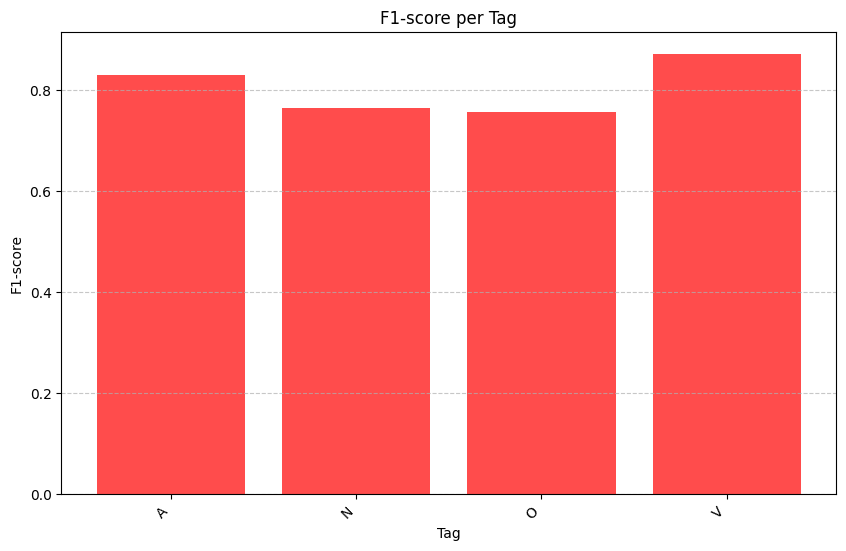

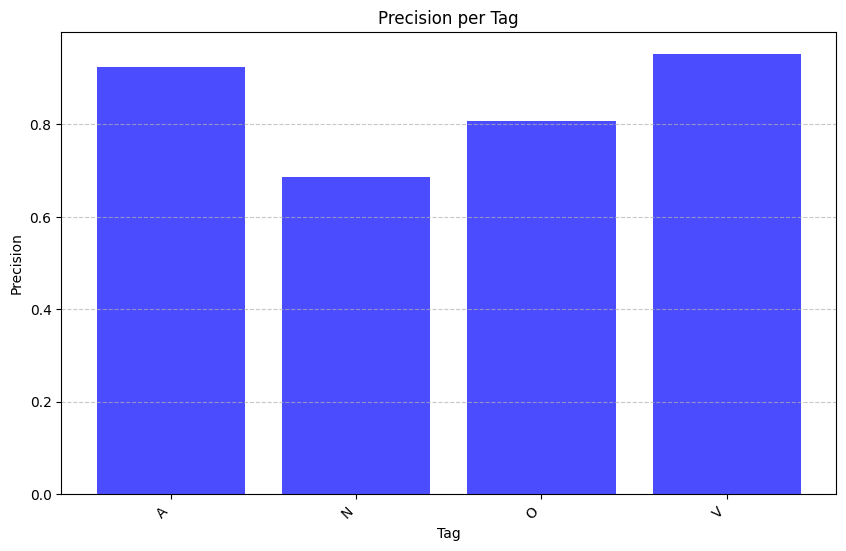

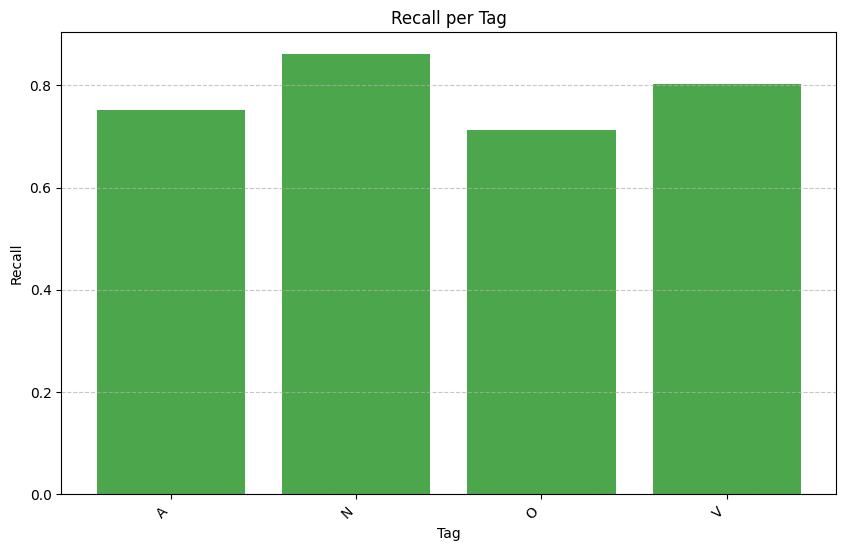


Overall Accuracy: 0.7833
Precision: 0.8428
Recall: 0.7819
F1-score: 0.8053

Tag-wise Accuracy:
Tag    Accuracy
---------------
    N    0.8611
    V    0.8022
    A    0.7510
    O    0.7134

Analyzing 1-Order HMM with tag_prev_word dependency (4 tags):


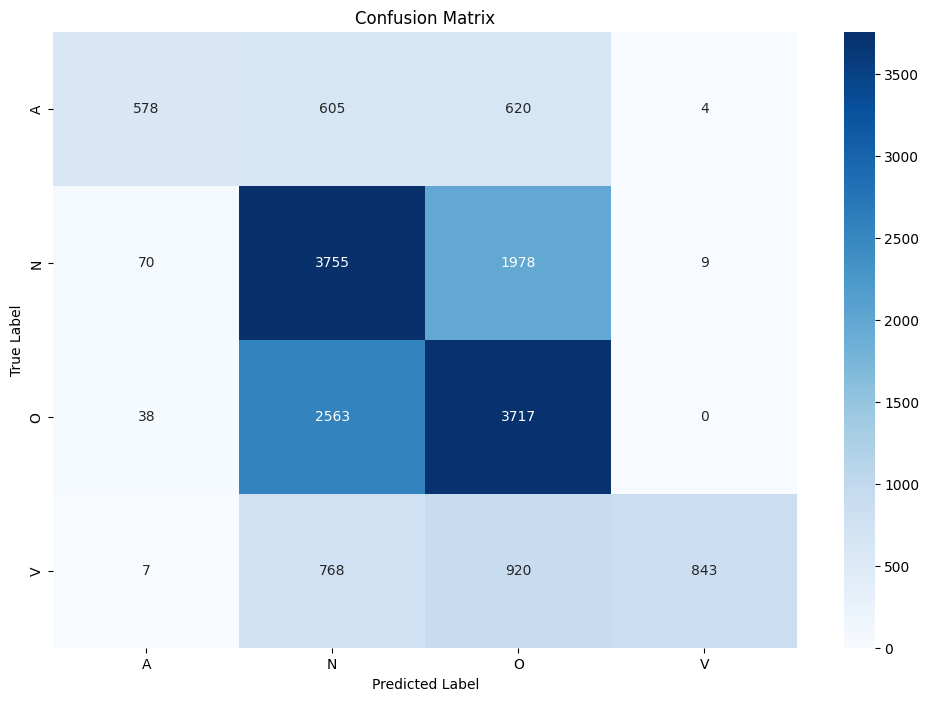

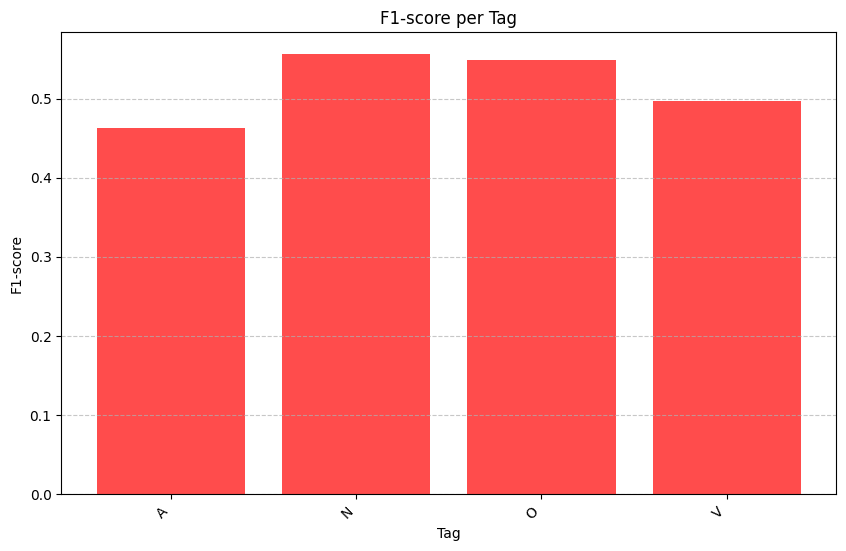

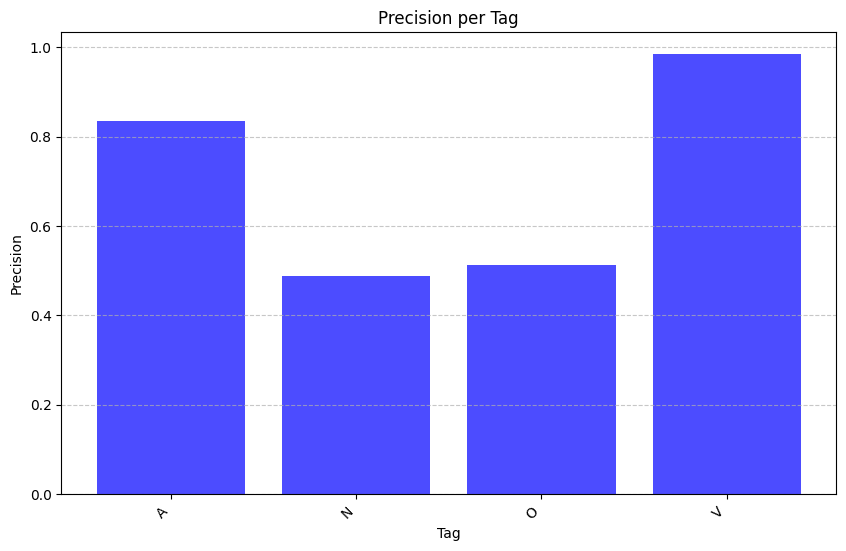

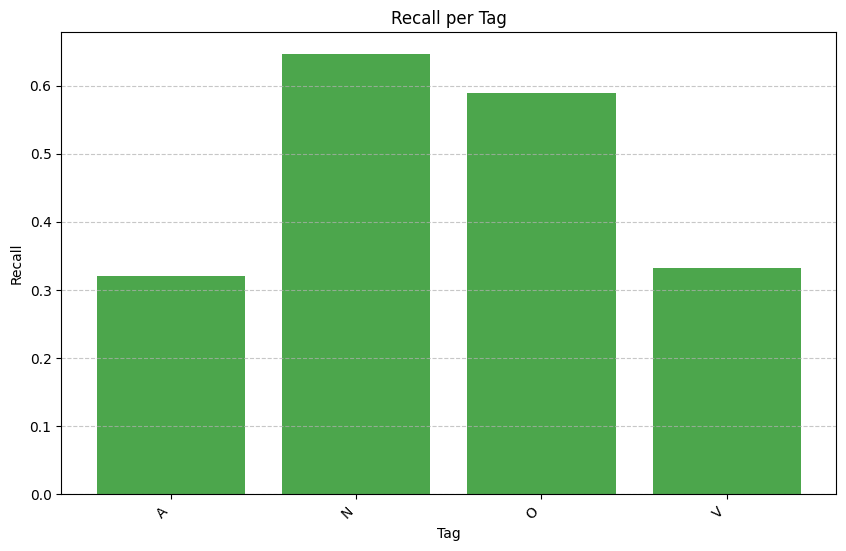


Overall Accuracy: 0.5398
Precision: 0.7052
Recall: 0.4716
F1-score: 0.5160

Tag-wise Accuracy:
Tag    Accuracy
---------------
    N    0.6461
    V    0.3322
    A    0.3199
    O    0.5883

Analyzing 2-Order HMM with tag dependency (4 tags):


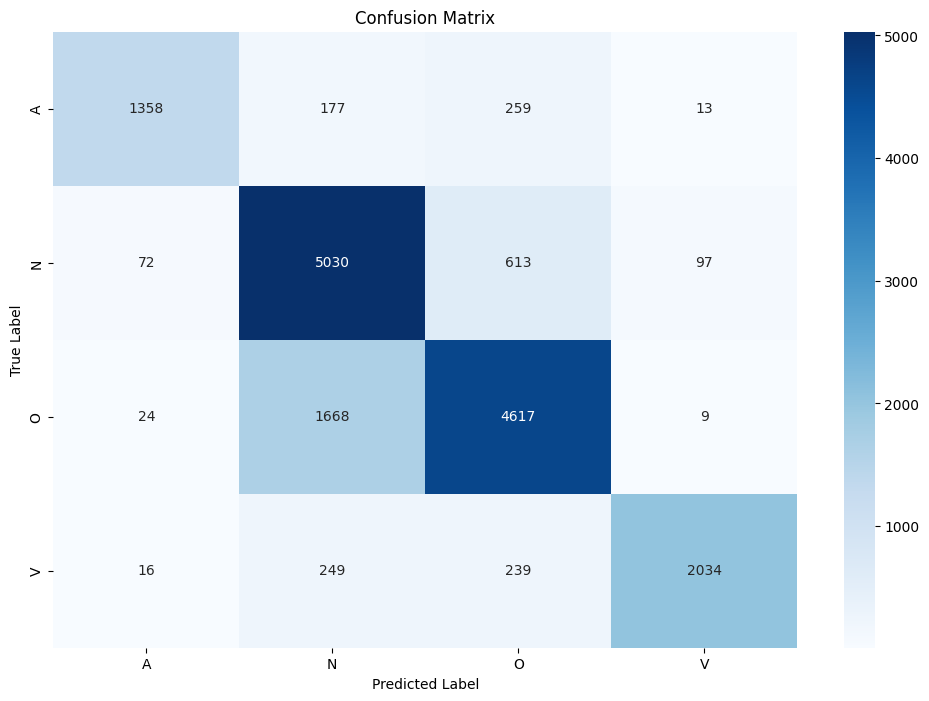

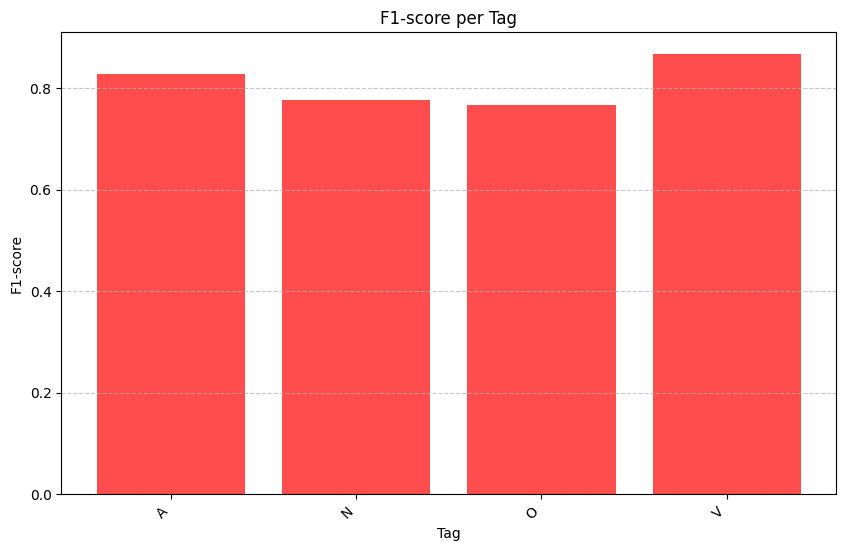

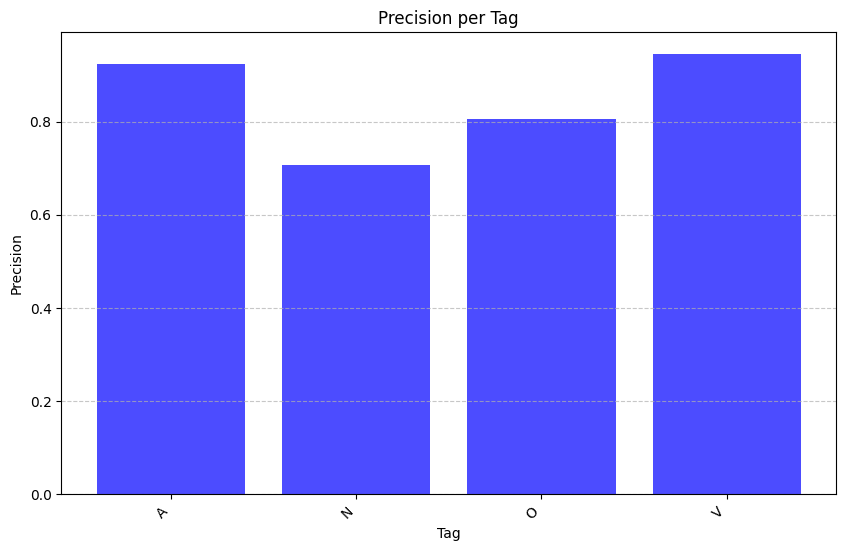

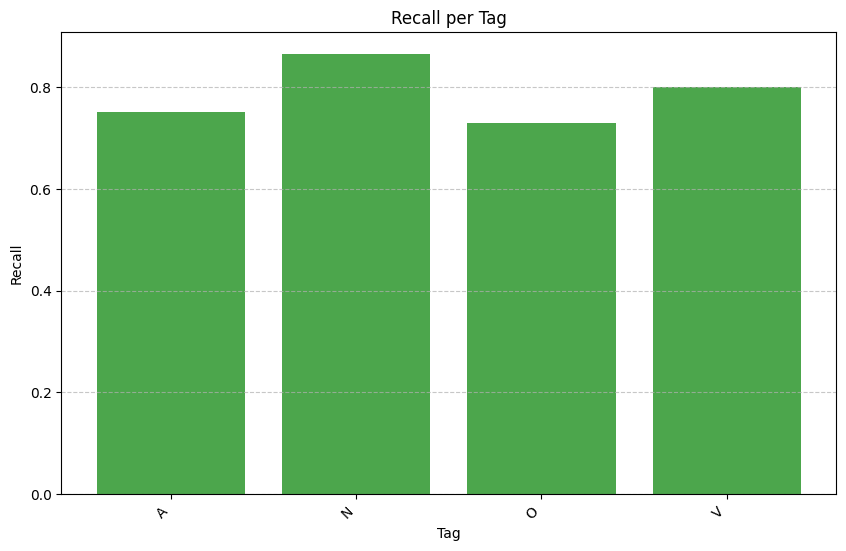


Overall Accuracy: 0.7914
Precision: 0.8452
Recall: 0.7873
F1-score: 0.8101

Tag-wise Accuracy:
Tag    Accuracy
---------------
    N    0.8655
    V    0.8014
    A    0.7515
    O    0.7308

Analyzing 2-Order HMM with tag_prev_word dependency (4 tags):


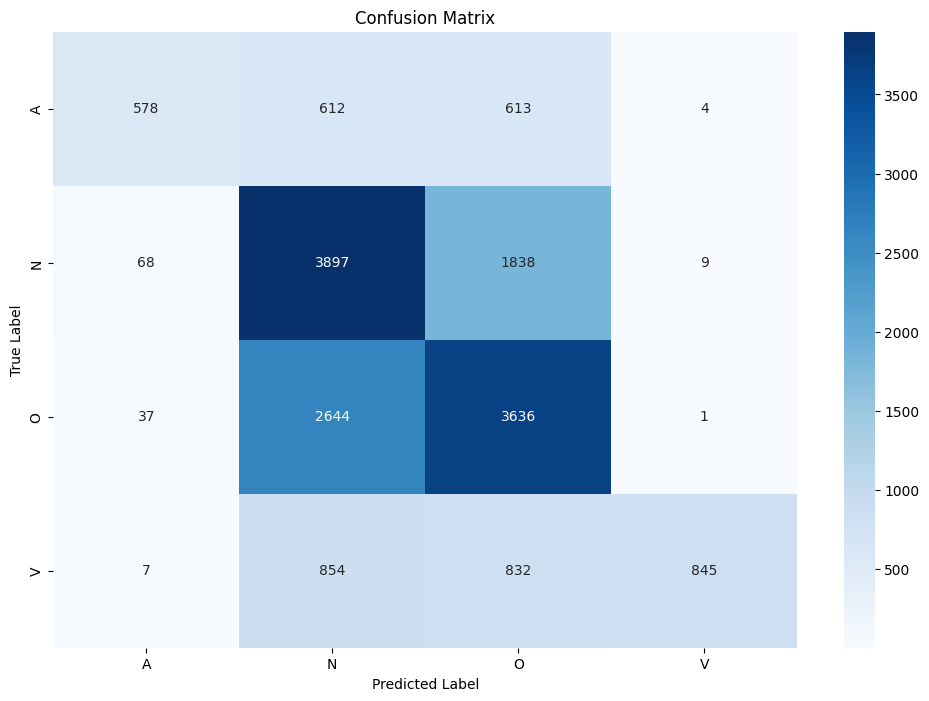

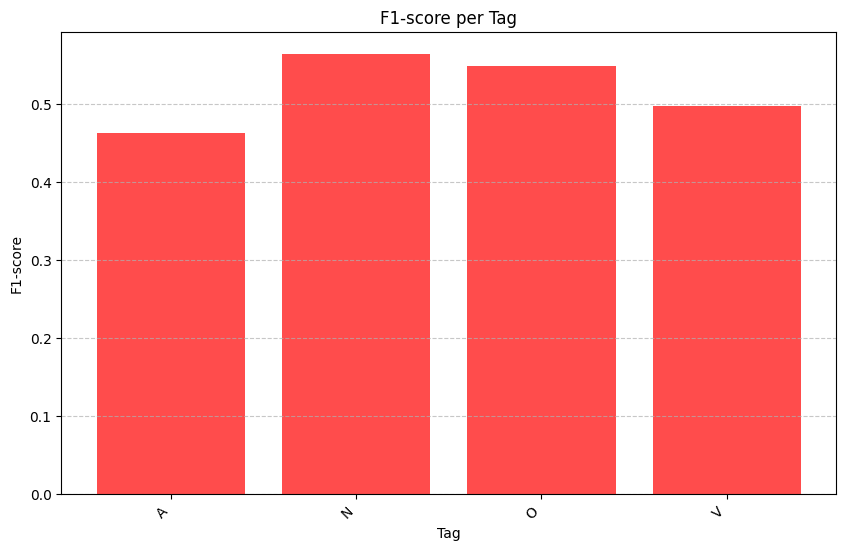

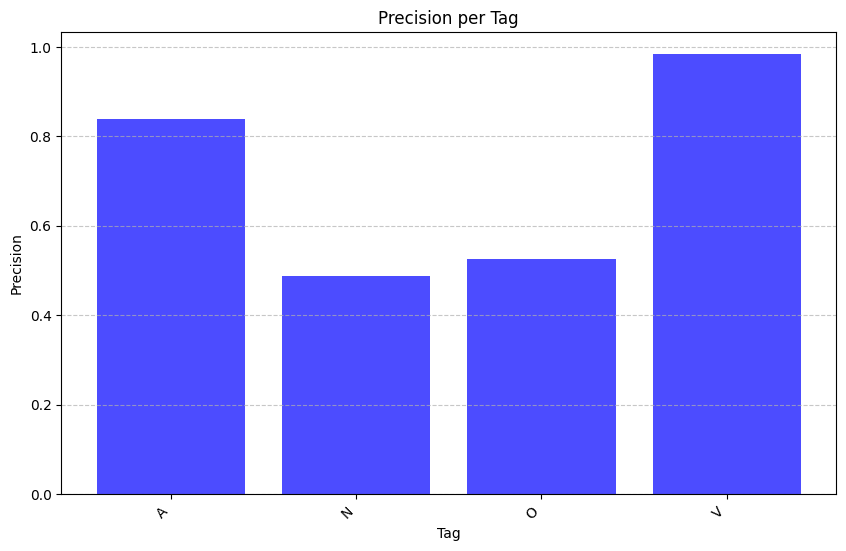

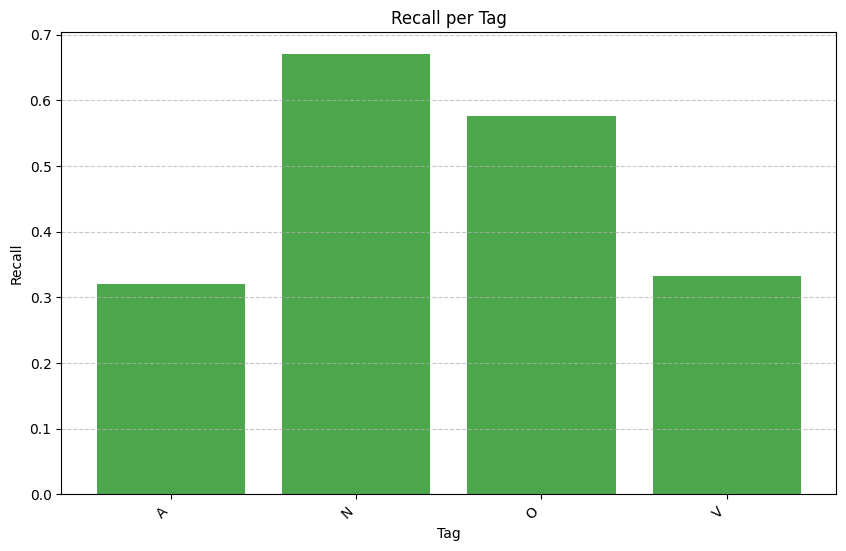


Overall Accuracy: 0.5436
Precision: 0.7084
Recall: 0.4747
F1-score: 0.5185

Tag-wise Accuracy:
Tag    Accuracy
---------------
    N    0.6705
    V    0.3329
    A    0.3199
    O    0.5755


In [45]:
print("\n=== 4-TAG MODEL ANALYSIS ===")

# Tag mapping for 4-tag reduction
tag_mapping = {
    "NN": "N", "NNS": "N", "NNP": "N", "NNPS": "N",
    "VB": "V", "VBD": "V", "VBG": "V", "VBN": "V", "VBP": "V", "VBZ": "V",
    "JJ": "A", "JJR": "A", "JJS": "A", "RB": "A", "RBR": "A", "RBS": "A",
}

# Convert data to 4 tags
train_data_4tags = [[(word, tag_mapping.get(tag, "O")) for word, tag in sent] for sent in train_data]
test_data_4tags = [[(word, tag_mapping.get(tag, "O")) for word, tag in sent] for sent in test_data]

# Test all configurations with 4 tags
for order in [1, 2]:
    for word_dep in ["tag", "tag_prev_word"]:
        print(f"\nAnalyzing {order}-Order HMM with {word_dep} dependency (4 tags):")
        model = HMMTagger(order=order, word_dependency=word_dep)
        model.train(train_data_4tags)
        acc, tag_acc, prec, rec, f1 = evaluate_model(model, test_data_4tags)  # Fixed unpacking

        print(f"\nOverall Accuracy: {acc:.4f}")
        print(f"Precision: {prec.mean():.4f}")
        print(f"Recall: {rec.mean():.4f}")
        print(f"F1-score: {f1.mean():.4f}")

        # Print detailed tag-wise accuracy
        print("\nTag-wise Accuracy:")
        print("Tag".ljust(5) + "Accuracy".rjust(10))
        print("-" * 15)
        for tag in ["N", "V", "A", "O"]:
            print(f"{tag:<5}{tag_acc.get(tag, 0):.4f}".rjust(15))
